In [1]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
pip install mojimoji

Note: you may need to restart the kernel to use updated packages.


In [3]:
import mojimoji

In [4]:
df_train = pd.read_csv(r'data\train.csv')
df_test = pd.read_csv(r'data\test.csv')

In [5]:
df_description = pd.read_csv(r'data\description.csv')

In [6]:
questionnaire_str_list = [q for q in df_description[df_description['カラム名'].str.contains('アンケート')].loc[:,'説明']]
print(questionnaire_str_list)
questionnaire_col_list = ['アンケート' + mojimoji.han_to_zen(str(i)) for i in range(1, 12)]
print(questionnaire_col_list)

['【質問内容】DX推進の戦略的な方向性はどの程度明確ですか？(1: 非常に低い, 2:低い, 3: 普通, 4:高い, 5: 非常に高い)', '【質問内容】社内のDX化に対する満足度はどの程度ですが？(1: 非常に低い, 2:低い, 3: 普通, 4:高い, 5: 非常に高い)', '【質問内容】最新デジタル技術（クラウド、AI、IoT等）の導入状況はどの程度進んでいますか？(1: 非常に低い, 2:低い, 3: 普通, 4:高い, 5: 非常に高い)', '【質問内容】社内のDX変革に対する抵抗感はどの程度ありますか？(1: 非常に低い, 2:低い, 3: 普通, 4:高い, 5: 非常に高い)', '【質問内容】サイバーセキュリティ対策の整備状況はどの程度十分ですか？(1: 非常に低い, 2:低い, 3: 普通, 4:高い, 5: 非常に高い)', '【質問内容】すでに業務プロセスの改善や自動化を目的としたツールやサービスを導入していますか？(1:はい, 2:いいえ)', '【質問内容】アンケート6が「はい」の場合、既存の業務プロセス改善ツールやサービスに対する満足度はどの程度ですか？(1: 非常に低い, 2:低い, 3: 普通, 4:高い, 5: 非常に高い)', '【質問内容】DXプロジェクトの成果や効果はどの程度実感されていますか？(1: 非常に低い, 2:低い, 3: 普通, 4:高い, 5: 非常に高い)', '【質問内容】新技術イベントやセミナーへの参加率はどの程度高いですか？(1: 非常に低い, 2:低い, 3: 普通, 4:高い, 5: 非常に高い)', '【質問内容】外部パートナー（ベンダー、コンサルタント等）とのDX連携実績はどの程度充実していますか？(1: 非常に低い, 2:低い, 3: 普通, 4:高い, 5: 非常に高い)', '【質問内容】DXに関する最新技術やツールの導入状況について、どの程度の情報収集を行っていますか？(1: 非常に低い, 2:低い, 3: 普通, 4:高い, 5: 非常に高い)']
['アンケート１', 'アンケート２', 'アンケート３', 'アンケート４', 'アンケート５', 'アンケート６', 'アンケート７', 'アンケート８', 'アンケート９', 'アンケート１０', 'アンケート１１']


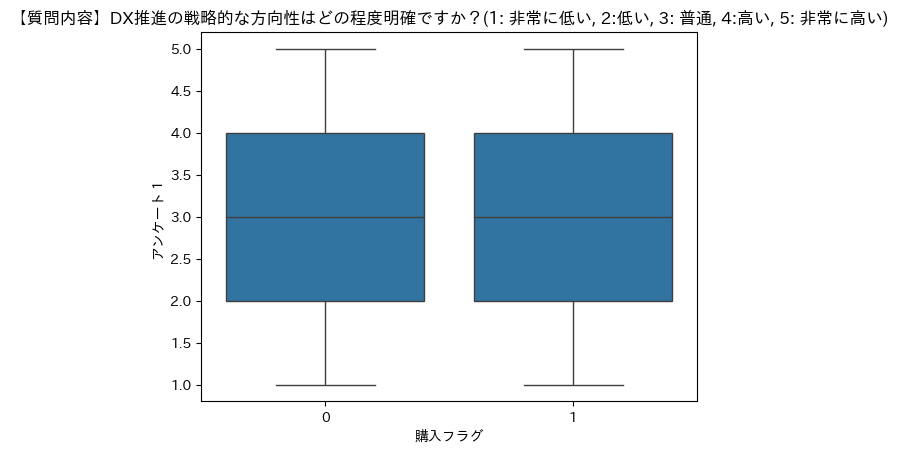

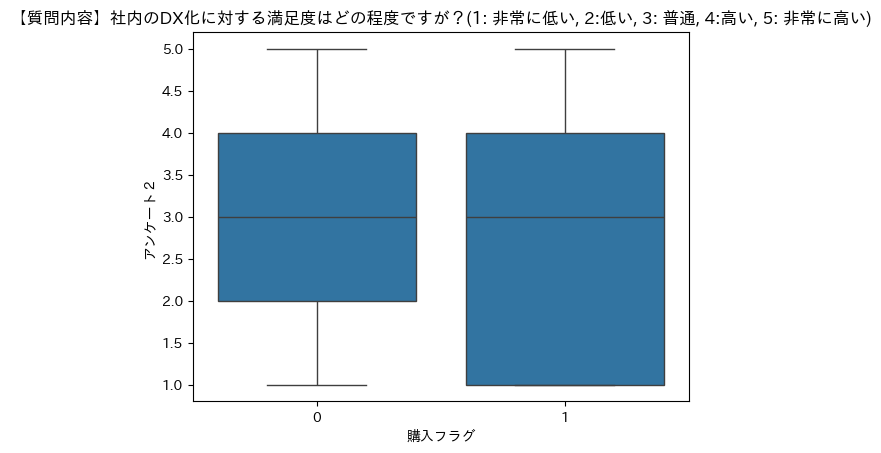

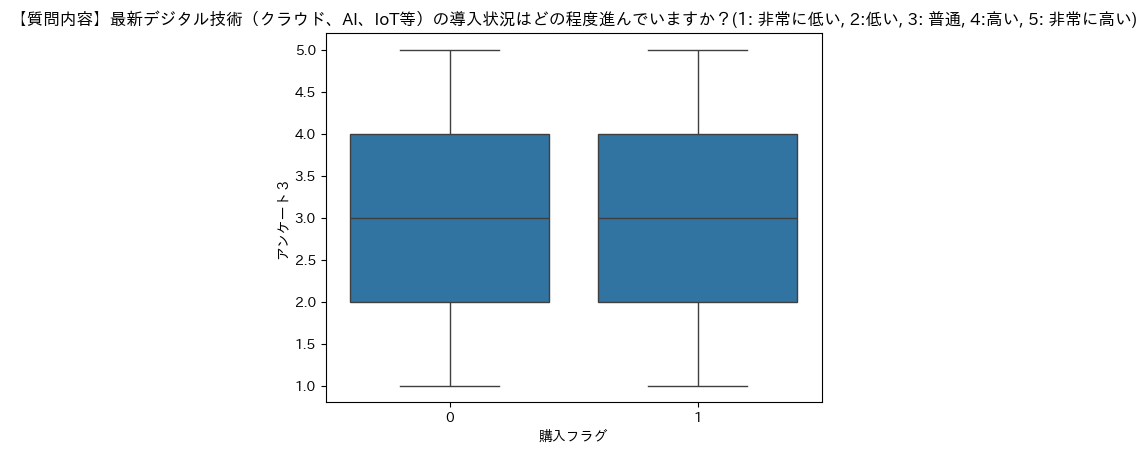

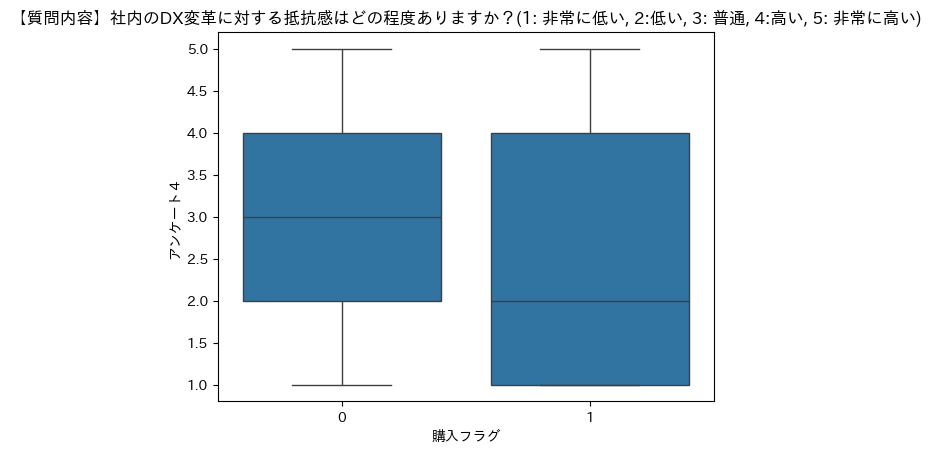

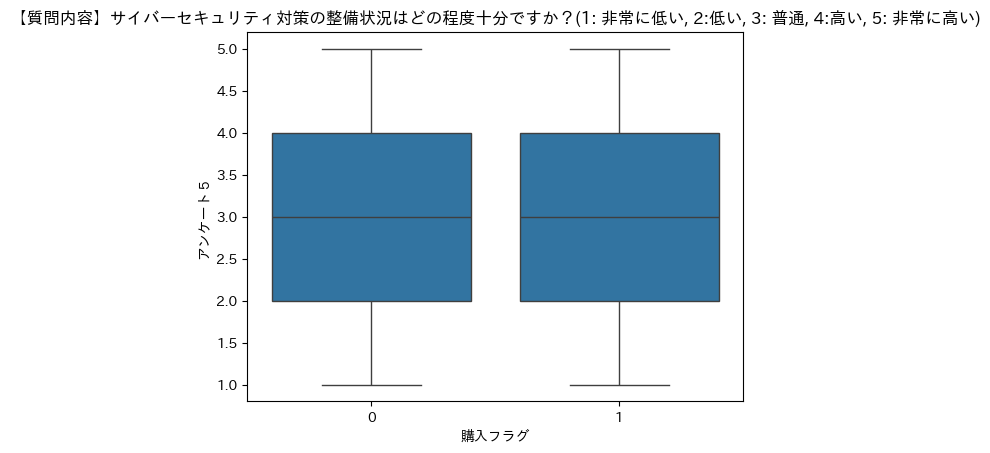

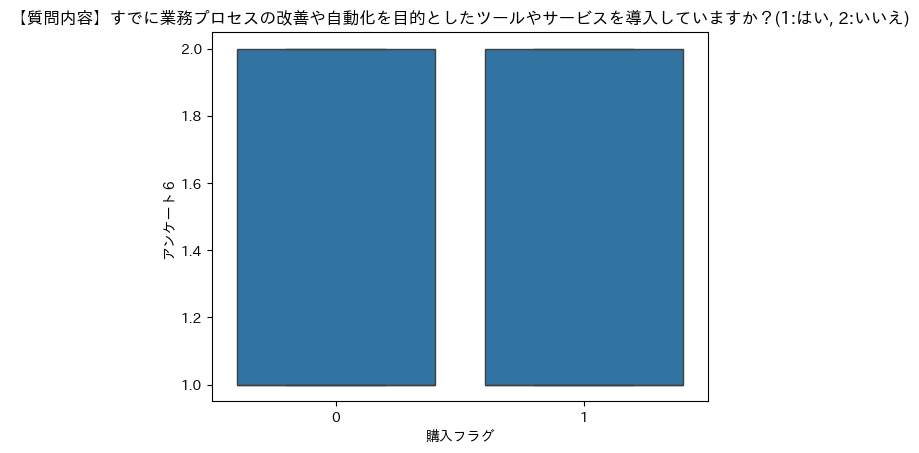

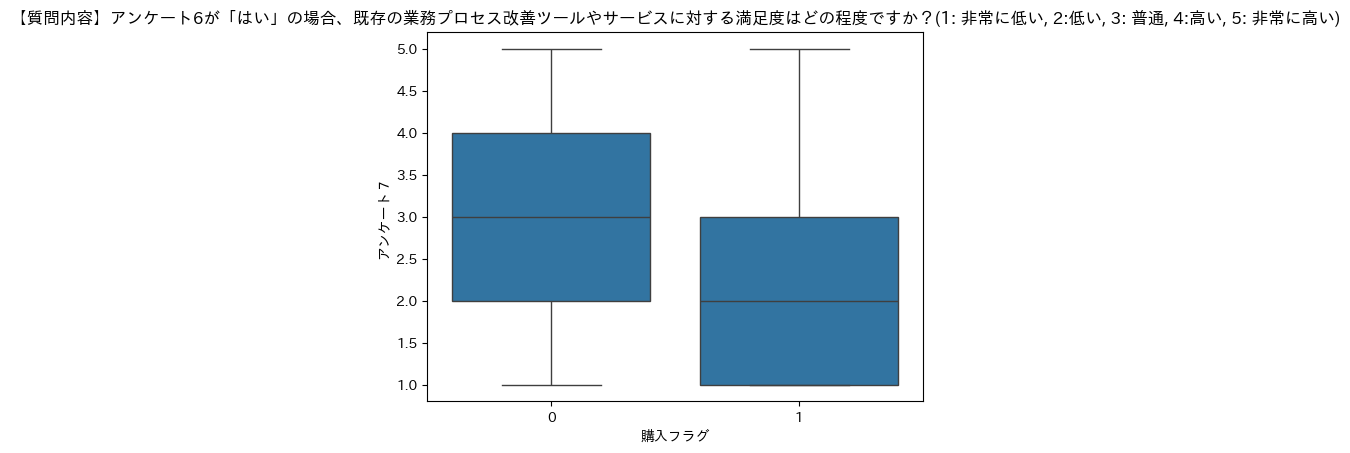

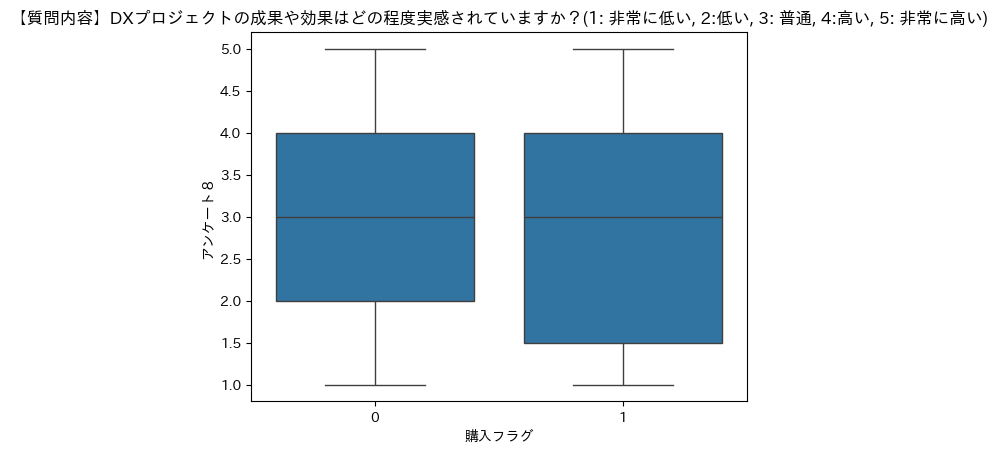

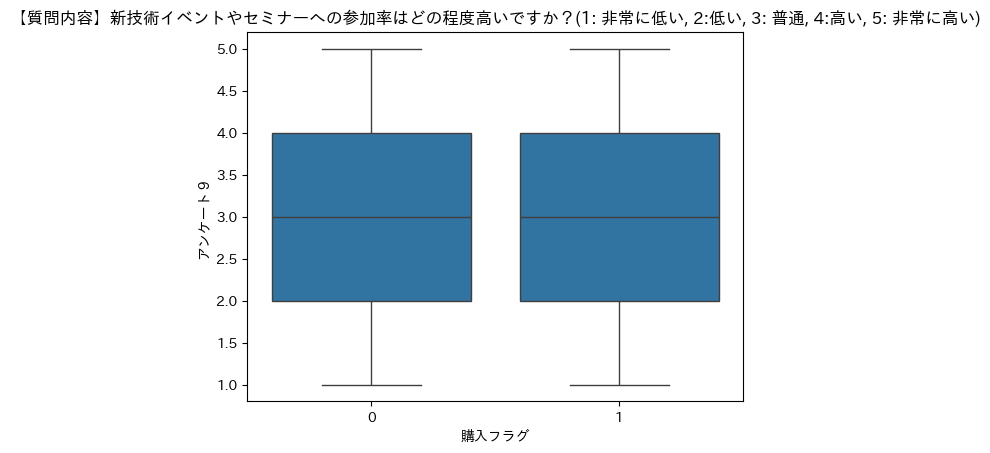

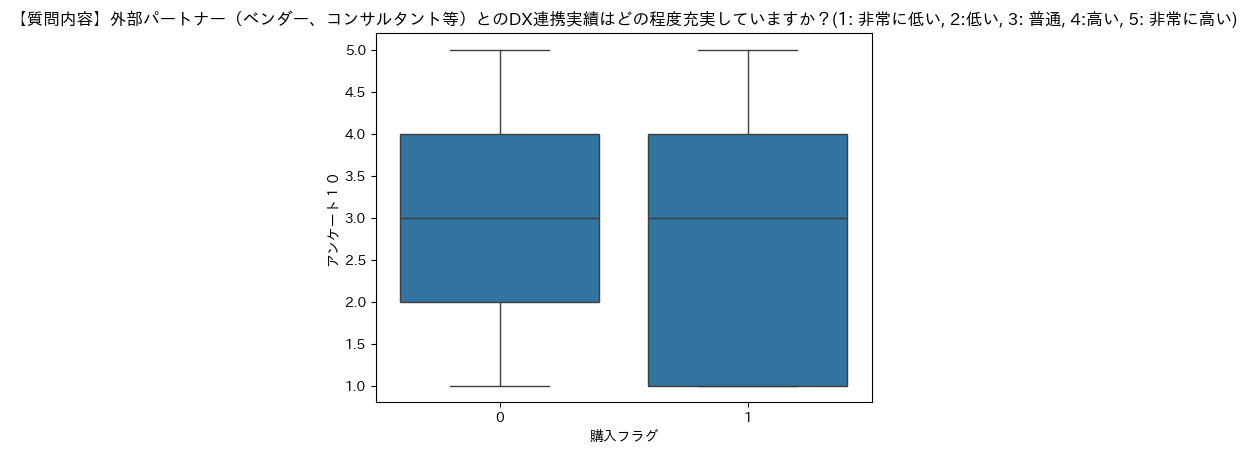

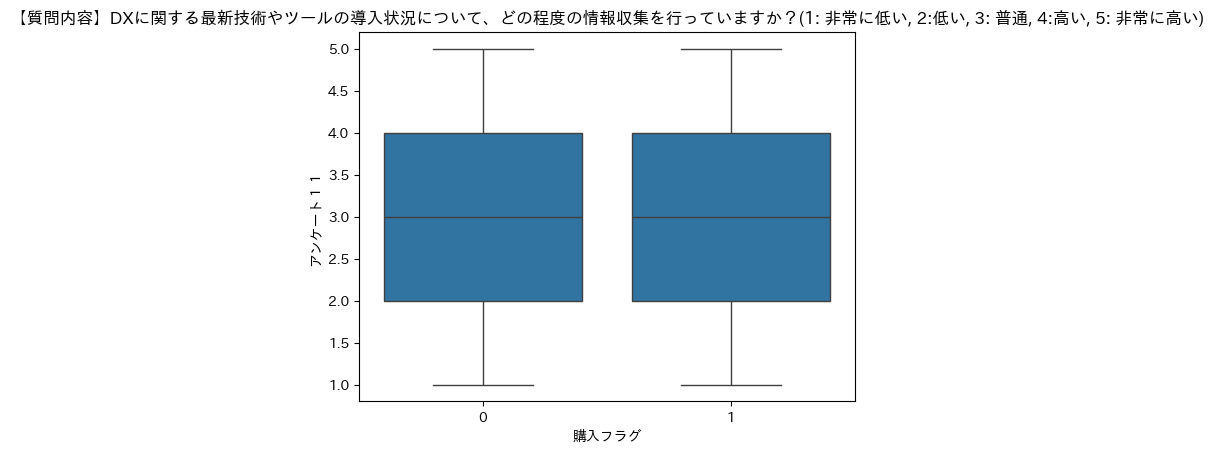

In [7]:
for i, v in enumerate(questionnaire_col_list):
    plt.figure()
    plt.title(questionnaire_str_list[i])
    sns.boxplot(x='購入フラグ', y=v, data=df_train)
    plt.show()


In [8]:
#アンケート2・10は「低評価＝不満」として逆スコア化：
df_train['アンケート2_逆'] = 6 - df_train['アンケート２']
df_train['アンケート10_逆'] = 6 - df_train['アンケート１０']

In [9]:
'''統合指標の再構成
- 不満度スコア：アンケート2_逆 + アンケート10_逆
- 抵抗感スコア：アンケート4（そのまま）
- 技術導入スコア：アンケート3, 5, 11（クラウド・セキュリティ・情報収集）
'''
df_train['不満度平均'] = df_train[['アンケート2_逆', 'アンケート10_逆']].mean(axis=1)
df_train['抵抗感'] = df_train['アンケート４']
df_train['技術導入平均'] = df_train[['アンケート３', 'アンケート５', 'アンケート１１']].mean(axis=1)


In [10]:
#相互作用特徴量
#「不満 × 抵抗感」「不満 × 技術導入」などの組み合わせが鍵になる可能性：
df_train['不満×抵抗感'] = df_train['不満度平均'] * df_train['抵抗感']
df_train['不満×技術導入'] = df_train['不満度平均'] * df_train['技術導入平均']
df_train['抵抗感×技術導入'] = df_train['抵抗感'] * df_train['技術導入平均']

In [11]:
print([col for col in df_train.columns if '×' in col])

['不満×抵抗感', '不満×技術導入', '抵抗感×技術導入']


In [12]:
import re
keywords = ["クラウド", "AI", "IoT", "自動化", "戦略", "課題", "成功"]
for kw in keywords:
    df_train[f"has_{kw}"] = df_train["今後のDX展望"].apply(lambda x: int(bool(re.search(kw, str(x)))))

In [13]:
pos_words = ["成功", "成長", "期待", "推進", "強化"]
neg_words = ["課題", "遅れ", "不安", "抵抗", "停滞"]
df_train["pos_score"] = df_train["今後のDX展望"].apply(lambda x: sum(x.count(w) for w in pos_words))
df_train["neg_score"] = df_train["今後のDX展望"].apply(lambda x: sum(x.count(w) for w in neg_words))

In [14]:
from janome.tokenizer import Tokenizer
tokenizer = Tokenizer()

def tokenize_meaningful(text):
    return [
        token.surface for token in tokenizer.tokenize(text)
        if token.part_of_speech.split(',')[0] in ['名詞', '動詞', '形容詞']
    ]

df_train["tokens"] = df_train["今後のDX展望"].fillna("").apply(tokenize_meaningful)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# トークンをスペースで結合して文書化
docs = df_train["tokens"].apply(lambda x: " ".join(x))
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(docs)

In [16]:
from gensim import corpora, models

# トークンリストを使って辞書とBoWを作成
dictionary = corpora.Dictionary(df_train["tokens"])
bow_corpus = [dictionary.doc2bow(text) for text in df_train["tokens"]]

In [17]:
lda_model = models.LdaModel(bow_corpus, num_topics=5, id2word=dictionary, passes=10)

# 各文書のトピック分布を抽出
topic_distributions = [lda_model.get_document_topics(bow) for bow in bow_corpus]

# トピック分布をDataFrame化
import pandas as pd
topic_df = pd.DataFrame([
    {f"topic_{i}": dict(doc).get(i, 0) for i in range(5)}
    for doc in topic_distributions
])

In [18]:
result_df = pd.concat([df_train[["企業ID"]], topic_df], axis=1)
print(result_df.head())

   企業ID  topic_0   topic_1   topic_2   topic_3   topic_4
0     0      0.0  0.785657  0.176092  0.000000  0.036842
1     1      0.0  0.288547  0.020796  0.534981  0.154889
2     2      0.0  0.000000  0.000000  0.000000  0.996689
3     3      0.0  0.000000  0.269983  0.517844  0.210603
4     4      0.0  0.853698  0.124216  0.000000  0.020482


In [19]:
for i in range(5):
    print(f"Topic {i}:")
    print(lda_model.print_topic(i, topn=10))

Topic 0:
0.006*"し" + 0.003*"的" + 0.002*"化" + 0.002*"これ" + 0.002*"する" + 0.002*"DX" + 0.001*"当社" + 0.001*"性" + 0.001*"投資" + 0.001*"段階"
Topic 1:
0.046*"し" + 0.030*"的" + 0.012*"DX" + 0.011*"化" + 0.011*"投資" + 0.011*"する" + 0.010*"段階" + 0.010*"これ" + 0.008*"業務" + 0.008*"導入"
Topic 2:
0.054*"し" + 0.024*"的" + 0.016*"化" + 0.014*"DX" + 0.011*"投資" + 0.010*"する" + 0.010*"これ" + 0.007*"導入" + 0.007*"段階" + 0.007*"さ"
Topic 3:
0.041*"し" + 0.032*"的" + 0.018*"する" + 0.015*"DX" + 0.013*"投資" + 0.009*"化" + 0.009*"既存" + 0.009*"社内" + 0.008*"段階" + 0.008*"導入"
Topic 4:
0.056*"し" + 0.020*"的" + 0.016*"DX" + 0.014*"化" + 0.013*"する" + 0.010*"さ" + 0.009*"これ" + 0.008*"技術" + 0.007*"投資" + 0.007*"デジタル"


In [20]:
final_df = pd.concat([df_train[["企業ID"]], topic_df], axis=1)

In [21]:
df_train = pd.merge(df_train, final_df.drop(columns=["企業ID"]), left_index=True, right_index=True)

In [22]:
# from sklearn.feature_extraction.text import CountVectorizer
# from gensim import corpora, models

# vectorizer = CountVectorizer(token_pattern=r"(?u)\\b\\w+\\b", max_features=1000)
# X = vectorizer.fit_transform(df_train["今後のDX展望"].fillna(""))
# corpus = [dict(zip(vectorizer.get_feature_names_out(), x.toarray()[0])) for x in X]
# dictionary = corpora.Dictionary([list(doc.keys()) for doc in corpus])
# bow_corpus = [dictionary.doc2bow(doc.keys()) for doc in corpus]
# lda_model = models.LdaModel(bow_corpus, num_topics=5, id2word=dictionary, passes=10)
# topic_features = [dict(lda_model.get_document_topics(bow)) for bow in bow_corpus]

In [23]:
print('train_data:', df_train.shape)
print('test_data:', df_test.shape)

train_data: (742, 66)
test_data: (800, 42)


In [24]:
df_train['自己資本比率'] = df_train['自己資本'] / df_train['総資産']
df_train['負債比率'] = df_train['負債'] / df_train['総資産']
df_train['流動比率'] = df_train['流動資産'] / df_train['負債']
df_train['営業利益率'] = df_train['営業利益'] / df_train['売上']
df_train['キャッシュフロー健全性'] = df_train['営業CF'] / df_train['売上']
df_train['DX投資効率'] = df_train['無形固定資産変動(ソフトウェア関連)'] * df_train['営業利益率']  #追加

In [25]:
#財務指標の正規化・対数変換
for col in ['売上', '総資産', '営業利益', '当期純利益']:
    df_train[f'{col}_log'] = np.log1p(df_train[col])

C:\Users\mitsu\anaconda3\envs\my_env\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mitsu\anaconda3\envs\my_env\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
print(df_train[['自己資本比率', '負債比率', '流動比率', '営業利益率', 'キャッシュフロー健全性']].isnull().sum())

自己資本比率          0
負債比率            0
流動比率            0
営業利益率          43
キャッシュフロー健全性     0
dtype: int64


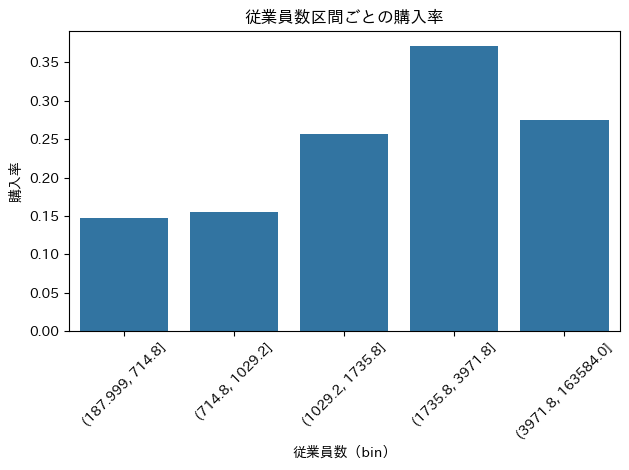

In [27]:
df_train['従業員数_bin'] = pd.qcut(df_train['従業員数'], q=5)
labor_cnt_dist = df_train.groupby('従業員数_bin')['購入フラグ'].mean()

# 可視化（barplot推奨）
sns.barplot(x=labor_cnt_dist.index.astype(str), y=labor_cnt_dist.values)
plt.xticks(rotation=45)
plt.ylabel('購入率')
plt.xlabel('従業員数（bin）')
plt.title('従業員数区間ごとの購入率')
plt.tight_layout()
plt.show()

In [28]:
# 業界ごとの営業利益率の平均を計算
industry_avg = df_train.groupby('業界')['営業利益率'].transform('median')
# 欠損値を業界平均で補完
df_train['営業利益率'] = df_train['営業利益率'].fillna(industry_avg)

In [29]:
# 業界ごとの購入率（購入フラグが1の割合）を計算
purchase_ratio_by_industry = df_train.groupby('業界')['購入フラグ'].mean()
# 結果を表示
print(purchase_ratio_by_industry.sort_values(ascending=False))

業界
通信機器        1.000000
通信          0.800000
人材          0.500000
IT          0.467742
自動車・乗り物     0.448980
コンサルティング    0.333333
金融          0.333333
教育          0.333333
機械          0.283019
ゲーム         0.250000
エネルギー       0.250000
商社          0.228571
化学          0.225806
その他サービス     0.222222
アパレル・美容     0.157895
製造          0.153846
電気製品        0.142857
エンタメ        0.142857
医療・福祉       0.125000
生活用品        0.117647
建設・工事       0.090909
運輸・物流       0.080000
食品          0.080000
不動産         0.076923
小売          0.073171
外食          0.050000
機械関連サービス    0.000000
広告          0.000000
その他         0.000000
マスコミ        0.000000
専門サービス      0.000000
Name: 購入フラグ, dtype: float64


In [30]:
industry_rate = df_train.groupby('業界')['購入フラグ'].mean()
threshold = industry_rate.quantile(0.75)  # 上位25%を高水準とする
print("高購入業界フラグの閾値: ", threshold)

# 業界ごとの購入率を計算
purchase_rate_by_industry = df_train.groupby('業界')['購入フラグ'].mean()

# 閾値以上の業界を抽出
high_purchase_industries = purchase_rate_by_industry[purchase_rate_by_industry >= threshold].index

# 高購入フラグ業界カラムを作成
df_train['高購入フラグ業界'] = df_train['業界'].apply(lambda x: 1 if x in high_purchase_industries else 0)

高購入業界フラグの閾値:  0.3081761006289308


In [31]:
df_train['高購入フラグ業界'].value_counts()

高購入フラグ業界
0    518
1    224
Name: count, dtype: int64

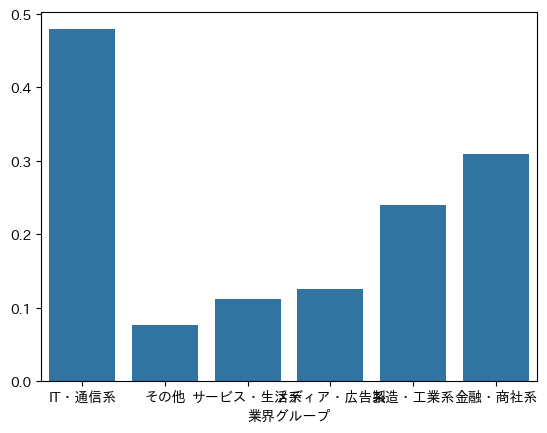

In [32]:
# 業界グループのマッピング辞書
industry_group_map = {
    '化学': '製造・工業系',
    '機械': '製造・工業系',
    '製造': '製造・工業系',
    '自動車・乗り物': '製造・工業系',
    '電気製品': '製造・工業系',
    '機械関連サービス': '製造・工業系',
    '建設・工事': '製造・工業系',
    'エネルギー': '製造・工業系',
    '食品': 'サービス・生活系',
    '医療・福祉': 'サービス・生活系',
    '生活用品': 'サービス・生活系',
    'アパレル・美容': 'サービス・生活系',
    '外食': 'サービス・生活系',
    '小売': 'サービス・生活系',
    'その他サービス': 'サービス・生活系',
    '教育': 'サービス・生活系',
    'IT': 'IT・通信系',
    '通信': 'IT・通信系',
    '通信機器': 'IT・通信系',
    'ゲーム': 'IT・通信系',
    '専門サービス': 'IT・通信系',
    '金融': '金融・商社系',
    '商社': '金融・商社系',
    '不動産': '金融・商社系',
    'コンサルティング': '金融・商社系',
    '人材': '金融・商社系',
    '広告': 'メディア・広告系',
    'マスコミ': 'メディア・広告系',
    'エンタメ': 'メディア・広告系',
    'その他': 'その他',
    '運輸・物流': 'その他'
}
# 新しいカラムを追加
df_train['業界グループ'] = df_train['業界'].map(industry_group_map)
avg_per_industries = df_train.groupby('業界グループ')['購入フラグ'].mean()
avg_per_industries.sort_values(ascending=False)
sns.barplot(x=avg_per_industries.index, y=avg_per_industries.values)
plt.show()

In [33]:
df_train.columns

Index(['企業ID', '企業名', '従業員数', '業界', '上場種別', '特徴', '企業概要', '組織図', '事業所数', '工場数',
       '店舗数', '資本金', '総資産', '流動資産', '固定資産', '負債', '短期借入金', '長期借入金', '純資産',
       '自己資本', '売上', '営業利益', '経常利益', '当期純利益', '営業CF', '減価償却費', '運転資本変動',
       '投資CF', '有形固定資産変動', '無形固定資産変動(ソフトウェア関連)', 'アンケート１', 'アンケート２', 'アンケート３',
       'アンケート４', 'アンケート５', 'アンケート６', 'アンケート７', 'アンケート８', 'アンケート９', 'アンケート１０',
       'アンケート１１', '今後のDX展望', '購入フラグ', 'アンケート2_逆', 'アンケート10_逆', '不満度平均', '抵抗感',
       '技術導入平均', '不満×抵抗感', '不満×技術導入', '抵抗感×技術導入', 'has_クラウド', 'has_AI',
       'has_IoT', 'has_自動化', 'has_戦略', 'has_課題', 'has_成功', 'pos_score',
       'neg_score', 'tokens', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', '自己資本比率', '負債比率', '流動比率', '営業利益率', 'キャッシュフロー健全性', 'DX投資効率',
       '売上_log', '総資産_log', '営業利益_log', '当期純利益_log', '従業員数_bin', '高購入フラグ業界',
       '業界グループ'],
      dtype='object')

In [34]:
# feature_list = [
#     '従業員数', '業界', '上場種別', '特徴', '企業概要', '組織図', '事業所数', '工場数',
#     '店舗数','不満度平均', '抵抗感','技術導入平均','不満×抵抗感','不満×技術導入', '抵抗感×技術導入',
#     '自己資本比率', '負債比率', '流動比率', '営業利益率', 'キャッシュフロー健全性', '従業員数_bin',
#     '高購入フラグ業界', '業界グループ','購入フラグ','has_クラウド', 'has_AI_x',
#        'has_IoT', 'has_自動化', 'has_戦略', 'has_課題', 'has_成功', 'pos_score_x',
#        'neg_score_x', 'tokens', 'has_AI_y', 'pos_score_y', 'neg_score_y',
#        'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 
# ]

In [35]:
# corr_matrix = df_train[feature_list].corr(numeric_only=True)
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.show()

In [36]:
# high_cardinal_column = [[col for col in df_train.columns if df_train[col].dtype == 'object' and df_train[col].nunique() > 10]]
# low_cardinal_column = [[col for col in df_train.columns if df_train[col].dtype == 'object' and df_train[col].nunique() <= 9]]
# print('high_cardinal_column: ', high_cardinal_column)
# print('low_cardinal_column: ', low_cardinal_column) 

In [37]:
df_train.columns

Index(['企業ID', '企業名', '従業員数', '業界', '上場種別', '特徴', '企業概要', '組織図', '事業所数', '工場数',
       '店舗数', '資本金', '総資産', '流動資産', '固定資産', '負債', '短期借入金', '長期借入金', '純資産',
       '自己資本', '売上', '営業利益', '経常利益', '当期純利益', '営業CF', '減価償却費', '運転資本変動',
       '投資CF', '有形固定資産変動', '無形固定資産変動(ソフトウェア関連)', 'アンケート１', 'アンケート２', 'アンケート３',
       'アンケート４', 'アンケート５', 'アンケート６', 'アンケート７', 'アンケート８', 'アンケート９', 'アンケート１０',
       'アンケート１１', '今後のDX展望', '購入フラグ', 'アンケート2_逆', 'アンケート10_逆', '不満度平均', '抵抗感',
       '技術導入平均', '不満×抵抗感', '不満×技術導入', '抵抗感×技術導入', 'has_クラウド', 'has_AI',
       'has_IoT', 'has_自動化', 'has_戦略', 'has_課題', 'has_成功', 'pos_score',
       'neg_score', 'tokens', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', '自己資本比率', '負債比率', '流動比率', '営業利益率', 'キャッシュフロー健全性', 'DX投資効率',
       '売上_log', '総資産_log', '営業利益_log', '当期純利益_log', '従業員数_bin', '高購入フラグ業界',
       '業界グループ'],
      dtype='object')

In [38]:
df_train['DXフラグ'] = df_train['組織図'].astype(str).str.contains('DX', na=False).astype(int)

In [39]:
#以下はCopilotに実装方法を聞いて出力されたコード

In [40]:
categorical_features = ['業界', '上場種別', '特徴', '従業員数_bin', '業界グループ']

for col in categorical_features:
    df_train[col] = df_train[col].astype(str).astype('category')

In [41]:
target = '購入フラグ'
#精度を上げるために指定のカラムで学習させる
features = [col for col in df_train.columns if col != target and col not in [
    '企業ID', '企業名', '企業概要', '組織図', '今後のDX展望',
    '事業所数', '工場数', '店舗数', '資本金', '総資産', '流動資産', '固定資産', '負債', '短期借入金', '長期借入金',
    '純資産', '自己資本','減価償却費', '運転資本変動', '投資CF', '有形固定資産変動', '不満度平均', '抵抗感', '技術導入平均','営業CF',
    '営業利益', '経常利益', '当期純利益',]]

final_df = pd.concat([df_train[["企業ID"]], topic_df], axis=1)

# 2. topic_df のみを df_train に追加
df_train = pd.concat([df_train, topic_df], axis=1)

# 3. NLP特徴量はすでに df_train にあるので features に追加するだけ
features += [f"has_{kw}" for kw in ["クラウド", "AI", "IoT", "自動化", "戦略", "課題", "成功"]]
features += ["pos_score", "neg_score"]
features += [f"topic_{i}" for i in range(5)]

features = [col for col in features if "アンケート" not in col]
# tokens列はLightGBMに渡すべきではないので除外
features = [col for col in features if col != "tokens"]
features = list(dict.fromkeys(features))
print(features)

from collections import Counter

column_counts = Counter(df_train.columns)
duplicates = [col for col, count in column_counts.items() if count > 1]
print("DataFrame内の重複列:", duplicates)

# 重複列を削除（最初の出現だけ残す）
df_train = df_train.loc[:, ~df_train.columns.duplicated()]


['従業員数', '業界', '上場種別', '特徴', '売上', '無形固定資産変動(ソフトウェア関連)', '不満×抵抗感', '不満×技術導入', '抵抗感×技術導入', 'has_クラウド', 'has_AI', 'has_IoT', 'has_自動化', 'has_戦略', 'has_課題', 'has_成功', 'pos_score', 'neg_score', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', '自己資本比率', '負債比率', '流動比率', '営業利益率', 'キャッシュフロー健全性', 'DX投資効率', '売上_log', '総資産_log', '営業利益_log', '当期純利益_log', '従業員数_bin', '高購入フラグ業界', '業界グループ', 'DXフラグ']
DataFrame内の重複列: ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4']


In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, df_train[target])):
    X_train = df_train.iloc[train_idx][features]
    y_train = df_train.iloc[train_idx][target]
    X_val = df_train.iloc[val_idx][features]
    y_val = df_train.iloc[val_idx][target]

    model = lgb.LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        class_weight='balanced',
        n_estimators=1000,
        learning_rate=0.05,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='binary_logloss',
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(period=0)
        ],
        categorical_feature=categorical_features
    )

    y_pred = model.predict(X_val)
    score = f1_score(y_val, y_pred)
    f1_scores.append(score)
    print(f'Fold {fold + 1} F1 Score: {score:.4f}')

print(f'\nAverage F1 Score: {np.mean(f1_scores):.4f}')

C:\Users\mitsu\anaconda3\envs\my_env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 指定されたファイルが見つかりません。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\mitsu\anaconda3\envs\my_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\mitsu\anaconda3\envs\my_env\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\mitsu\anaconda3\envs\my_env\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\mitsu\anaconda3\envs\my_env\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Info] Number of positive: 143, number of negative: 450
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3157
[LightGBM] [Info] Number of data points in the train set: 593, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [43]:
print('train_column: ', X_train.columns)
print('test_column: ', X_val.columns)

train_column:  Index(['従業員数', '業界', '上場種別', '特徴', '売上', '無形固定資産変動(ソフトウェア関連)', '不満×抵抗感',
       '不満×技術導入', '抵抗感×技術導入', 'has_クラウド', 'has_AI', 'has_IoT', 'has_自動化',
       'has_戦略', 'has_課題', 'has_成功', 'pos_score', 'neg_score', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', '自己資本比率', '負債比率', '流動比率',
       '営業利益率', 'キャッシュフロー健全性', 'DX投資効率', '売上_log', '総資産_log', '営業利益_log',
       '当期純利益_log', '従業員数_bin', '高購入フラグ業界', '業界グループ', 'DXフラグ'],
      dtype='object')
test_column:  Index(['従業員数', '業界', '上場種別', '特徴', '売上', '無形固定資産変動(ソフトウェア関連)', '不満×抵抗感',
       '不満×技術導入', '抵抗感×技術導入', 'has_クラウド', 'has_AI', 'has_IoT', 'has_自動化',
       'has_戦略', 'has_課題', 'has_成功', 'pos_score', 'neg_score', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', '自己資本比率', '負債比率', '流動比率',
       '営業利益率', 'キャッシュフロー健全性', 'DX投資効率', '売上_log', '総資産_log', '営業利益_log',
       '当期純利益_log', '従業員数_bin', '高購入フラグ業界', '業界グループ', 'DXフラグ'],
      dtype='object')


In [44]:
keywords = ["クラウド", "AI", "IoT", "自動化", "戦略", "課題", "成功"]
for kw in keywords:
    df_test[f"has_{kw}"] = df_test["今後のDX展望"].apply(lambda x: int(bool(re.search(kw, str(x)))))

In [45]:
pos_words = ["成功", "成長", "期待", "推進", "強化"]
neg_words = ["課題", "遅れ", "不安", "抵抗", "停滞"]
df_test["pos_score"] = df_test["今後のDX展望"].apply(lambda x: sum(x.count(w) for w in pos_words))
df_test["neg_score"] = df_test["今後のDX展望"].apply(lambda x: sum(x.count(w) for w in neg_words))

In [46]:
# トークン化（df_trainと同じ関数を使用）
df_test["tokens"] = df_test["今後のDX展望"].fillna("").apply(tokenize_meaningful)

# BoW変換（df_trainで構築した dictionary を使用）
bow_corpus_test = [dictionary.doc2bow(text) for text in df_test["tokens"]]

# トピック分布抽出（df_trainで学習済みの lda_model を使用）
topic_distributions_test = [lda_model.get_document_topics(bow) for bow in bow_corpus_test]

# DataFrame化
topic_df_test = pd.DataFrame([
    {f"topic_{i}": dict(doc).get(i, 0) for i in range(5)}
    for doc in topic_distributions_test
])

# 結合
df_test = pd.concat([df_test, topic_df_test], axis=1)

In [47]:
# 1. アンケート逆スコア化
df_test['アンケート2_逆'] = 6 - df_test['アンケート２']
df_test['アンケート10_逆'] = 6 - df_test['アンケート１０']

# 2. 統合指標
df_test['不満度平均'] = df_test[['アンケート2_逆', 'アンケート10_逆']].mean(axis=1)
df_test['抵抗感'] = df_test['アンケート４']
df_test['技術導入平均'] = df_test[['アンケート３', 'アンケート５', 'アンケート１１']].mean(axis=1)

# 3. 相互作用特徴量
df_test['不満×抵抗感'] = df_test['不満度平均'] * df_test['抵抗感']
df_test['不満×技術導入'] = df_test['不満度平均'] * df_test['技術導入平均']
df_test['抵抗感×技術導入'] = df_test['抵抗感'] * df_test['技術導入平均']

# 4. 財務比率
df_test['自己資本比率'] = df_test['自己資本'] / df_test['総資産']
df_test['負債比率'] = df_test['負債'] / df_test['総資産']
df_test['流動比率'] = df_test['流動資産'] / df_test['負債']
df_test['営業利益率'] = df_test['営業利益'] / df_test['売上']
df_test['キャッシュフロー健全性'] = df_test['営業CF'] / df_test['売上']
df_test['DX投資効率'] = df_test['無形固定資産変動(ソフトウェア関連)'] * df_test['営業利益率'] #追加

# 5. 対数変換
for col in ['売上', '総資産', '営業利益', '当期純利益']:
    df_test[f'{col}_log'] = np.log1p(df_test[col])

# 6. 従業員数ビニング（trainと同じ区間で）
df_train['従業員数_bin'], bins = pd.qcut(df_train['従業員数'], q=5, retbins=True, duplicates='drop')#追加
#df_test['従業員数_bin'] = pd.cut(df_test['従業員数'], bins=df_train['従業員数_bin'].cat.categories)
df_test['従業員数_bin'] = pd.cut(df_test['従業員数'], bins=bins, include_lowest=True)
df_test['従業員数_bin'] = df_test['従業員数_bin'].astype(str).astype('category')  #追加(LightGBMのため)

# 7. 高購入業界フラグ（trainで定義した業界リストを使用）
df_test['高購入フラグ業界'] = df_test['業界'].apply(lambda x: 1 if x in high_purchase_industries else 0)

# 8. 業界グループ分類（trainと同じ辞書を使用）
df_test['業界グループ'] = df_test['業界'].map(industry_group_map)

# 9. DXフラグ（組織図に"DX"を含むか）
df_test['DXフラグ'] = df_test['組織図'].astype(str).str.contains('DX', na=False).astype(int)

# 10. カテゴリ変数の型変換（LightGBM用）
for col in ['業界', '上場種別', '特徴', '従業員数_bin', '業界グループ']:
    df_test[col] = df_test[col].astype(str).astype('category')

C:\Users\mitsu\anaconda3\envs\my_env\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mitsu\anaconda3\envs\my_env\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
print(df_test[features].columns)

Index(['従業員数', '業界', '上場種別', '特徴', '売上', '無形固定資産変動(ソフトウェア関連)', '不満×抵抗感',
       '不満×技術導入', '抵抗感×技術導入', 'has_クラウド', 'has_AI', 'has_IoT', 'has_自動化',
       'has_戦略', 'has_課題', 'has_成功', 'pos_score', 'neg_score', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', '自己資本比率', '負債比率', '流動比率',
       '営業利益率', 'キャッシュフロー健全性', 'DX投資効率', '売上_log', '総資産_log', '営業利益_log',
       '当期純利益_log', '従業員数_bin', '高購入フラグ業界', '業界グループ', 'DXフラグ'],
      dtype='object')


In [49]:
y_test_pred = model.predict(df_test[features])

In [50]:
submission = pd.DataFrame({
    '企業ID': df_test['企業ID'],
    '予測購入フラグ': y_test_pred
})
submission.to_csv('submission.csv', index=False, header=False)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


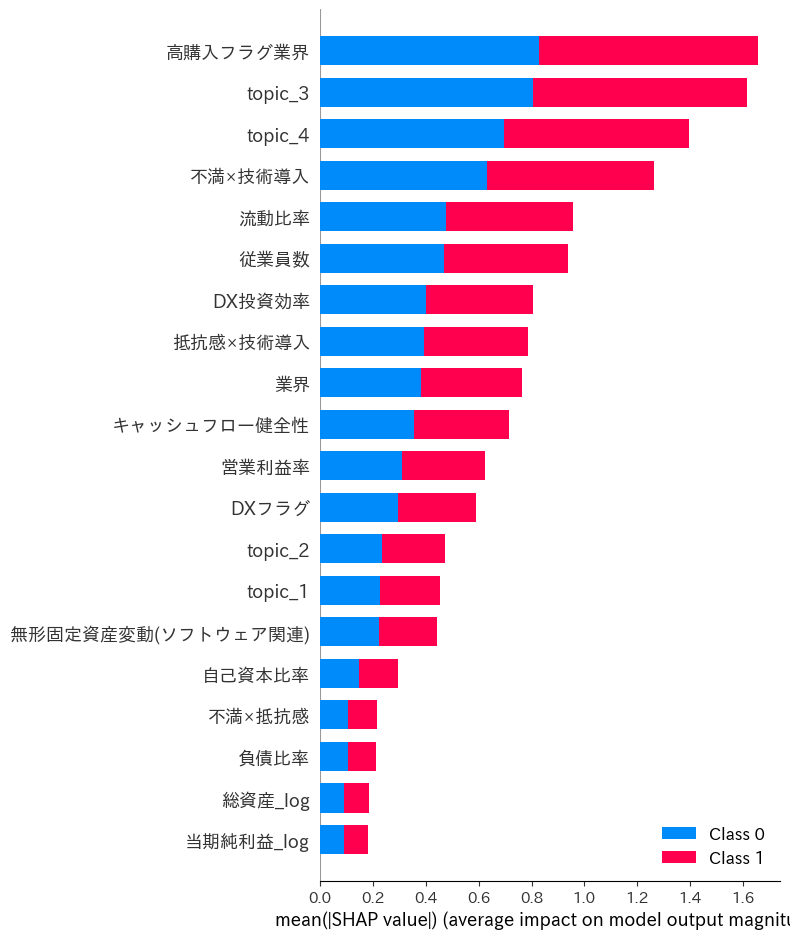

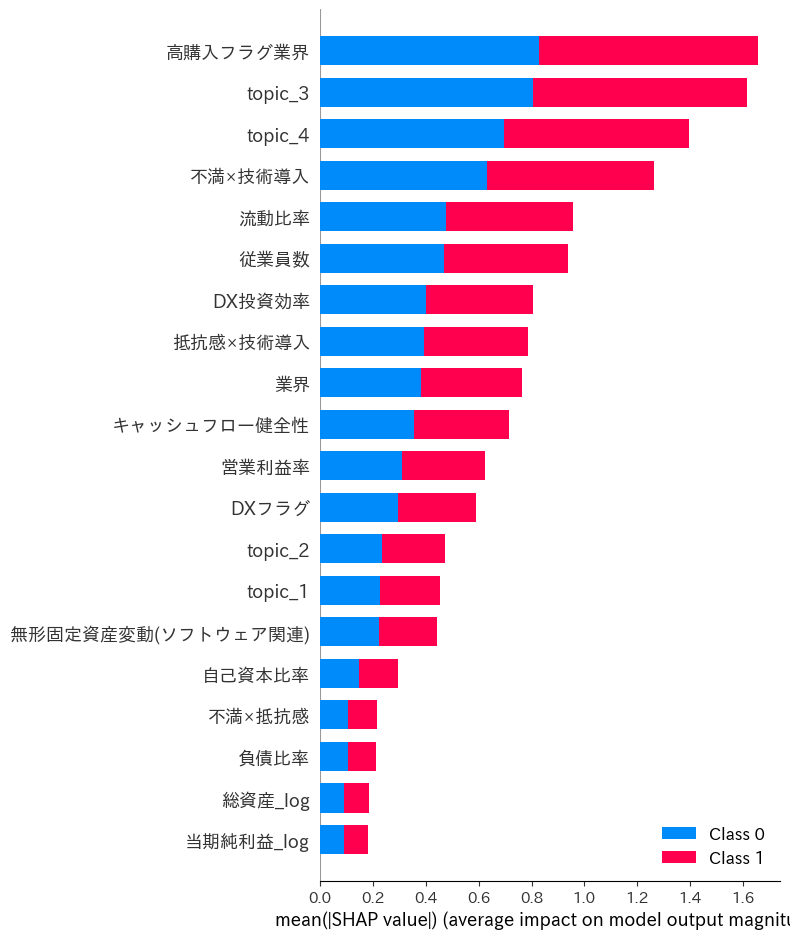

In [51]:
import shap
import matplotlib.pyplot as plt

# SHAPのTreeExplainerを使ってモデル解釈
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

# 特徴量の重要度（棒グラフ）
shap.summary_plot(shap_values, X_val, plot_type="bar")

# 特徴量の分布と影響（散布図）
shap.summary_plot(shap_values, X_val)

In [52]:
for i in range(5):
    print(f"Topic {i}:")
    print(lda_model.print_topic(i, topn=10))

Topic 0:
0.006*"し" + 0.003*"的" + 0.002*"化" + 0.002*"これ" + 0.002*"する" + 0.002*"DX" + 0.001*"当社" + 0.001*"性" + 0.001*"投資" + 0.001*"段階"
Topic 1:
0.046*"し" + 0.030*"的" + 0.012*"DX" + 0.011*"化" + 0.011*"投資" + 0.011*"する" + 0.010*"段階" + 0.010*"これ" + 0.008*"業務" + 0.008*"導入"
Topic 2:
0.054*"し" + 0.024*"的" + 0.016*"化" + 0.014*"DX" + 0.011*"投資" + 0.010*"する" + 0.010*"これ" + 0.007*"導入" + 0.007*"段階" + 0.007*"さ"
Topic 3:
0.041*"し" + 0.032*"的" + 0.018*"する" + 0.015*"DX" + 0.013*"投資" + 0.009*"化" + 0.009*"既存" + 0.009*"社内" + 0.008*"段階" + 0.008*"導入"
Topic 4:
0.056*"し" + 0.020*"的" + 0.016*"DX" + 0.014*"化" + 0.013*"する" + 0.010*"さ" + 0.009*"これ" + 0.008*"技術" + 0.007*"投資" + 0.007*"デジタル"
